In [4]:
import sys

sys.path.append('..')
from common.time_layers import *
import pickle
import numpy as np

In [11]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100,
                 hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 初始化权重
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 生成层
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 将所有的权重和梯度整理到列表中
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [6]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

In [7]:
# 设定超参数
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN的隐藏状态向量的元素个数
time_size = 35  # RNN的展开大小
lr = 20.0
max_epoch = 4
max_grad = 0.25

In [8]:
# 读入训练数据
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [13]:
# 生成模型
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9998.01
| epoch 1 |  iter 21 / 1327 | time 3[s] | perplexity 2798.35
| epoch 1 |  iter 41 / 1327 | time 7[s] | perplexity 1258.05
| epoch 1 |  iter 61 / 1327 | time 10[s] | perplexity 969.35
| epoch 1 |  iter 81 / 1327 | time 13[s] | perplexity 801.00
| epoch 1 |  iter 101 / 1327 | time 17[s] | perplexity 645.01
| epoch 1 |  iter 121 / 1327 | time 20[s] | perplexity 637.70
| epoch 1 |  iter 141 / 1327 | time 24[s] | perplexity 597.97
| epoch 1 |  iter 161 / 1327 | time 27[s] | perplexity 585.71
| epoch 1 |  iter 181 / 1327 | time 30[s] | perplexity 586.13
| epoch 1 |  iter 201 / 1327 | time 33[s] | perplexity 510.08
| epoch 1 |  iter 221 / 1327 | time 37[s] | perplexity 486.10
| epoch 1 |  iter 241 / 1327 | time 40[s] | perplexity 434.68
| epoch 1 |  iter 261 / 1327 | time 43[s] | perplexity 461.83
| epoch 1 |  iter 281 / 1327 | time 46[s] | perplexity 441.30
| epoch 1 |  iter 301 / 1327 | time 50[s] | perplexity 380.13
| epoch 1 |  i

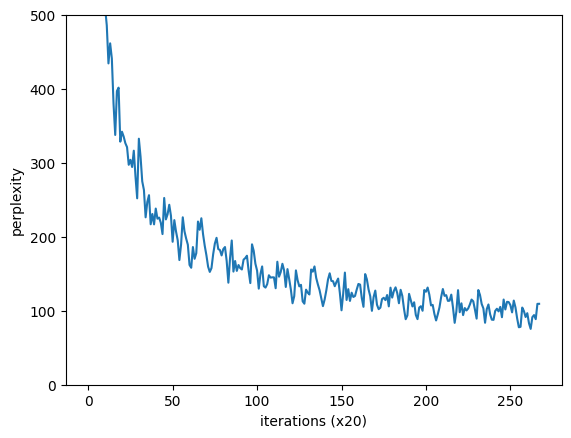

In [14]:
# ❶ 应用梯度裁剪进行学习
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

In [15]:
# ❷ 基于测试数据进行评价
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

evaluating perplexity ...
234 / 235
test perplexity:  135.53508866518175


In [16]:
# ❸ 保存参数
model.save_params()